# Figure 11: AF Lep b - parameters

## 1. Imports

In [1]:
from copy import deepcopy
from pathlib import Path
import sys
import subprocess

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.ndimage import gaussian_filter
from configparser import ConfigParser
import cmocean

from orvara import corner_modified
from orvara.orbit_plots import Orbit
from orvara.main_plotting import initialize_plot_options

from fours.utils.data_handling import read_fours_root_dir

## 2. Preparations

This plot needs [orvara](https://github.com/t-brandt/orvara) to run the MCMC analysis and to create the plot. Make sure to install it.

**Note:** orvara and some packages used by orvara are not maintained. This leads to compatibility issues with numpy. We noticed that most issues can be solved by installing an over version of ``numpy``. You can change your version by running:

In [ ]:
%pip install numpy==1.23.0

This old numpy version may cause problems with other parts of the ``fours`` code. Be sure to revert the installation after the experiment is complete.

### Information about the data

1. The HIP number of AF Lep is 25486

2. The HGCA file can directly be copied from the orvara main directory. Filename: HGCA_vEDR3.fits

3. The RV data is taken from HIRES between 2002 and 2013 \[Butler, R. P., Vogt, S. S., Laughlin, G., et al. 2017, AJ, 153, 208\] and copied to the file AF_Lep_RV.txt

4. For the relative astrometry, apart from the NaCo L'-band data point the following other observations are available:

- VLT/NACO	2011-Nov	Bonse
- Keck/NIRC2	2021-Dez	Franson
- VLT/SPHERE	2022-Oct	Mesa
- VLT/SPHERE	2022-Oct	de Rosa
- VLT/SPHERE	2022-Dez	Mesa
- Keck/NIRC2	2023-Feb	Franson

5. The GAIA epochs and scan angles (GAIADataDir) are retrieved via: https://gaia.esac.esa.int/gost/

6. The original Hipparcos reduction for HIP1DataDir is retrieved from the following website: https://hipparcos-tools.cosmos.esa.int/cgi-bin/HIPcatalogueSearch.pl?hipiId=25486
Note, that the ID number at the end of the URL is the HIP number of the target in question.

7. For the HIP2DataDir, the reduction from van Leeuwen are downloaded from https://www.cosmos.esa.int/web/hipparcos/hipparcos-2 (under point 3)

Priors: 
As done in Branson et al. 2023, we set the host star mass prior to 1.2+-0.06 solar masses

**MCMC setup:**
- 20 temperatures
- 100 walkers
- 5000 steps per walker


## 3. Create config for orvara

Orvara needs a config file to run the MCMC analysis for the orbit fit.

We read in a general config file and adapt the links to match with the **FOURS_ROOT_DIR**.

In [2]:
root_dir = Path(read_fours_root_dir())

Data in the FOURS_ROOT_DIR found. Location: /fast/mbonse/s4


Read the general config file.

In [3]:
config = ConfigParser()
_= config.read(str(root_dir / Path("30_data/af_lep_parameters/config_all.ini")))

Set the directories and files needed.

In [4]:
config['data_paths']['HGCAFile'] = str(root_dir / Path(config['data_paths']['HGCAFile']))
config['data_paths']['RVFile'] = str(root_dir / Path(config['data_paths']['RVFile']))
config['data_paths']['AstrometryFile'] = str(root_dir / Path(config['data_paths']['AstrometryFile']))
config['data_paths']['GaiaDataDir'] = str(root_dir / Path(config['data_paths']['GaiaDataDir']))
config['data_paths']['Hip1DataDir'] = str(root_dir / Path(config['data_paths']['Hip1DataDir']))
config['data_paths']['Hip2DataDir'] = str(root_dir / Path(config['data_paths']['Hip2DataDir']))

# if you want to use your own MCMC run change the McmcDataFile to the file created in the next step
config['plotting']['McmcDataFile'] = str(root_dir / Path(config['plotting']['McmcDataFile']))

In [5]:
# Save the modified config file
config_path = root_dir / "30_data/af_lep_parameters/config_local.ini"
with open(config_path, 'w') as configfile:
    config.write(configfile)

## 4. Run orvara

In [6]:
# Define the output directory as a variable
output_dir = str(root_dir / "70_results/x4_af_lep/")

# Define the path to the config file
config_file = str(root_dir / "30_data/af_lep_parameters/config_local.ini")

# Construct the command using the variables
command = f"fit_orbit --output-dir {output_dir} {config_file}"

# Execute the command
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Print the output and any errors
print("Output:", result.stdout)
print("Error:", result.stderr)

Output: Unable to load relative RV data from file 
Loadied 19 RV data points from file /fast/mbonse/s4/30_data/af_lep_parameters/AF_Lep_RV.txt
Loaded data from 1 RV instruments.
Loading astrometric data for 1 planets
Loaded 6 relative astrometric data points from file /fast/mbonse/s4/30_data/af_lep_parameters/AF_Lep_RelAstro_all.txt
Loading absolute astrometry data for Hip 25486
Recognized a 5-parameter fit in Gaia for Hip 25486
Not using companion proper motion from Gaia.
Using ptemcee.
Running MCMC ... 
[                              ]  0%
[                              ]  1%
[                              ]  2%
[                              ]  3%
[#                             ]  4%
[#                             ]  5%
[#                             ]  6%
[##                            ]  7%
[##                            ]  8%
[##                            ]  9%
[###                           ] 10%
[###                           ] 11%
[###                           ] 12%
[####   

This might take some time... Once completed there will be a new file in the ``70_results/x4_af_lep`` folder which contains the results of your MCMC analysis. You can change ``config['plotting']['McmcDataFile']`` to the file ``AF Lep b_chain000.fits`` or continue with our result ``af_lep_chain_all.fits``.

## 5. Load the results of the MCMC analysis

The ``orvara`` code is usually run from the command line. To generate the output in a jupyter notebook we have to set the command line arguments.

In [7]:
original_argv = sys.argv.copy()

In [8]:
sys.argv = ['script_name', config_file, 
            '--output-dir', output_dir]

In [9]:
# initialize the OP class object
OPs = initialize_plot_options(config)

# create the orbit object
orbit = Orbit(OPs)

Generating plots for target AF Lep b


In [10]:
sys.argv = original_argv

## 6. Create the plot

In [11]:
def transform_to_sky(orbit, keepout_angle=259.2+90, dkoa=50):
    """
    Transform the orbit coordinates to sky coordinates.
    """

    # order the orbit coordinates
    ang_coords = np.array((deepcopy(orbit.relsep), ((deepcopy(orbit.PA+90)) * np.pi/180) % (2*np.pi))).T
    ang_coords = ang_coords[ang_coords[:, 1].argsort()]
    
    # convert to sky coordinates
    coords = np.array((ang_coords[:, 0] * np.cos(ang_coords[:, 1]), ang_coords[:, 0] * np.sin(ang_coords[:, 1])))
    
    return coords

In [12]:
def get_xy_position(angle, distance_arsec):
    angle_radians = np.deg2rad(angle-90)
    distance = distance_arsec

    # Calculate x and y coordinates
    x = distance * np.cos(angle_radians)
    y = distance * np.sin(angle_radians)
    
    return -x, -y

In [13]:
# sky coordinates for the most likely orbit
coords = transform_to_sky(orbit)

In [14]:
# sky coordinates for the randomly selected orbits
sel_coords = []
for i in range(len(OPs.rand_idx)):
    orb = Orbit(OPs, step=OPs.rand_idx[i]) 
    sel_coords.append(transform_to_sky(orb))

In [15]:
def plot_orbits(ax):
    for i in range(len(sel_coords)):
        ax.plot(sel_coords[i][0], sel_coords[i][1], color='k', alpha=0.05)
    
    ax.scatter(0, 0, marker="*", color="k", alpha=0.8, lw=2,zorder=2, s=80)
    
    msize = 100
    
    color_new = 'orange'
    
    datapoints = [['NaCo - Nov 2011', 259.2, 0.318, 'x', 'k'],
                  ['Keck - Dec 2021', 62.8, 0.338, '+', color_new],
                  ['SPHERE - Oct 2022', 70.2, 0.335, '1', color_new],
                  [None, 70.3, 0.339, '1', color_new],
                  ['SPHERE - Dez 2022', 70.8, 0.332, '2', color_new],
                  ['Keck - Feb 2023', 72.0, 0.342, 'x', color_new]]
    
    for d in datapoints:
        ax.scatter(*get_xy_position(d[1], d[2]),
                      marker=d[3],
                      color=d[4],
                      alpha=1, lw=2,
                      label=d[0],
                    zorder=2,
                      s=msize)
        
    ax.plot(coords[0], coords[1], color='k', label='Best fit orbit', zorder=1)
    
    ax.scatter(-0.1, -0.172, marker=(3, 0, 250), color='k')
    ax.scatter(0.1, 0.168, marker=(3, 0, 70), color='k')

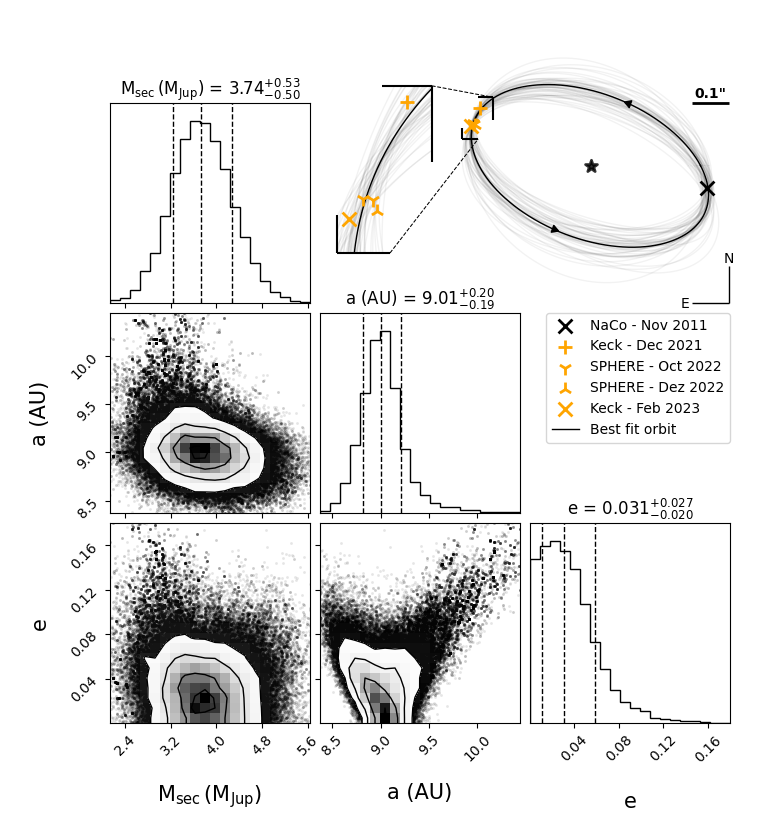

In [16]:
rcParams["lines.linewidth"] = 1.0
rcParams["axes.labelpad"] = 20.0
rcParams["xtick.labelsize"] = 10.0
rcParams["ytick.labelsize"] = 10.0

chain = OPs.chain

Mpri = chain['mpri']
npl = '%d' % (OPs.iplanet)
if OPs.cmref == 'msec_solar':
    Msec = chain['msec' + npl]         # in M_{\odot}
    labels=[r'$\mathrm{M_{pri}\, (M_{\odot})}$', 
            r'$\mathrm{M_{sec}\, (M_{\odot})}$', 
            'a (AU)', 
            r'e', 
            r'$\mathrm{i\, (^{\circ})}$']
else:
    Msec = chain['msec' + npl]*1989/1.898
    labels=[r'$\mathrm{M_{sec}\, (M_{Jup})}$', 'a (AU)', r'e']
Semimajor = chain['sau' + npl]
Ecc = chain['esino' + npl]**2 + chain['ecoso' + npl]**2
Inc = chain['inc' + npl]

chain = np.vstack([Msec, Semimajor, Ecc]).T

# in corner_modified, the error is modified to keep 2 significant figures
figure = corner_modified.corner(
    chain, 
    labels=labels, 
    quantiles=[0.16, 0.5, 0.84], 
    range=[0.999 for l in labels],
    verbose=False, 
    show_titles=True, 
    title_kwargs={"fontsize": 12}, 
    hist_kwargs={"lw":1.}, 
    label_kwargs={"fontsize":15}, 
    xlabcord=(0.5,-0.45), 
    ylabcord=(-0.45,0.5))

ax = plt.axes((0.56, 0.66, 0.41, 0.41))

plot_orbits(ax)

plt_lim = 0.42
ax.set_xlim(-plt_lim, plt_lim)
ax.set_ylim(-plt_lim, plt_lim)

size_position = -0.37
ax.hlines([-size_position-0.2, ], 
             xmin=-size_position, 
             xmax=-size_position - 0.1,
             color='k', lw=2)
ax.text(
    x=-size_position - 0.05 , 
    y=-size_position -0.195, 
    s='0.1"', color='k', ha='center', va='bottom', 
    fontsize=10,
    fontweight="bold")

ax.vlines(
    x=-size_position, 
    ymin=size_position, 
    ymax=size_position+0.1,
    color='k')

ax.hlines(
    y=size_position,
    xmin=-size_position-0.1,
    xmax=-size_position,
    color='k')

ax.text(
    x=-size_position,
    y=size_position+0.1, 
    s='N',
    color='k', 
    ha='center',
    va='bottom',
    fontsize=10)

ax.text(
    x=-size_position-0.105, 
    y=size_position-0.003, 
    s='E',
    color='k', 
    ha='right', 
    va='center', 
    fontsize=10)

ax.set_xticks([])
ax.set_yticks([])

ax.patch.set_alpha(0.0001)
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

ax.legend(loc='upper center', 
          bbox_to_anchor=(0.65, 0.05), 
          ncol=1, fontsize=10)


midpoint = np.array(get_xy_position(70.2, 0.335)) + np.array((0.005, 0.013))
delta = np.array((0.02, 0.035))

ax2 = plt.axes((0.43, 0.75, 0.22*delta[0]/delta[1], 0.22))
plot_orbits(ax2)

#ax2.patch.set_alpha(0.0001)
ax2.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])


ax2.set_xlim(midpoint[0]-delta[0], midpoint[0]+delta[0])
ax2.set_ylim(midpoint[1]-delta[1], midpoint[1]+delta[1])

ax3 = plt.axes((0, 0, 1, 1), frameon=False)
ax3.set_xticks([])
ax3.set_yticks([])

lw = 1.5
bracket_i = {'x': 0.555, 
             'y': 0.97, 
             'dy': 0.1, 
             'scale': 0.65}

bracket_o = {'x': 0.635, 
             'y': 0.955, 
             'dy': 0.03, 
             'scale': 0.65}

stop_i = {'x': 0.43, 
             'y': 0.75, 
             'dy': 0.05, 
             'scale': 1.4}

stop_o = {'x': 0.595, 
             'y': 0.9, 
             'dy': 0.015, 
             'scale': 1.4}


ax3.vlines(x=bracket_i['x'], 
           ymin=bracket_i['y']-bracket_i['dy'], 
           ymax=bracket_i['y'], 
           color='k', lw=lw)
ax3.hlines(y=bracket_i['y'], 
           xmin=bracket_i['x'] - bracket_i['dy'] * bracket_i['scale'], 
           xmax=bracket_i['x'], 
           color='k', lw=lw)

ax3.vlines(x=bracket_o['x'], 
           ymin=bracket_o['y']-bracket_o['dy'], 
           ymax=bracket_o['y'], 
           color='k', lw=lw)
ax3.hlines(y=bracket_o['y'], 
           xmin=bracket_o['x'] - bracket_o['dy'] * bracket_o['scale'], 
           xmax=bracket_o['x'], 
           color='k', lw=lw)

ax3.vlines(x=stop_i['x'], 
           ymin=stop_i['y'], 
           ymax=stop_i['y'] + stop_i['dy'], 
           color='k', lw=lw)
ax3.hlines(y=stop_i['y'], 
           xmin=stop_i['x'], 
           xmax=stop_i['x'] + stop_i['dy'] * stop_i['scale'], 
           color='k', lw=lw)

ax3.vlines(x=stop_o['x'], 
           ymin=stop_o['y'], 
           ymax=stop_o['y'] + stop_o['dy'], 
           color='k', lw=lw)
ax3.hlines(y=stop_o['y'], 
           xmin=stop_o['x'], 
           xmax=stop_o['x'] + stop_o['dy'] * stop_o['scale'], 
           color='k', lw=lw)

ax3.plot([bracket_i['x'], bracket_o['x']], [bracket_i['y'], bracket_o['y']], color='k', lw=lw/2, ls='--')
ax3.plot([stop_i['x'] + stop_i['dy'] * stop_i['scale'], 
          stop_o['x'] + stop_o['dy'] * stop_o['scale']], 
         [stop_i['y'], stop_o['y']], color='k', lw=lw/2, ls='--')

ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)

# save the figure
plt.savefig("./final_plots/06_af_lep_orbit.pdf", bbox_inches='tight')